In [ ]:
"""
    Python notebook for sentiment visualization as a graph problem
    And other experimentations: centrality measures, correlations, one way tests.
"""

In [1]:
import json
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
country = 'GB'
# Load the dictionary of the current teams
file_title = country + '/' + country + '_twitter.json'
dct = dict()
with open(file_title, 'r') as j:
     dct = json.loads(j.read())

In [4]:
# Create a map frequency by team
# For example this will increase the importance with less tweeted teams
def return_index(index):
    if index == -1:
        return 2
    if index == 1:
        return 0
    if index == 0:
        return 1

# For sentiment [positive, neutral, negative]
# For support [home_team, both, away_team]
def group_distribution(grouped, dct):
    dct_teams = dict()
    for ite, row in grouped.iterrows():
        home_team = dct[ite[0]]['mention'][1:].lower()
        away_team = dct[ite[1]]['mention'][1:].lower()
        if home_team not in dct_teams:
            dct_teams[home_team] = 0
        if away_team not in dct_teams:
            dct_teams[away_team] = 0
        if ite[2] == 1:
            dct_teams[home_team]+=row["season"]
        if ite[2] == -1:
            dct_teams[away_team]+=row["season"]
        if  ite[2] == 0:
            dct_teams[home_team]+=row["season"]//2
            dct_teams[away_team]+=row["season"]//2
    return dct_teams

In [5]:
# Function that returns the user of the home/away team given a support
def support_team(row):
    if row['m_support'] == 1:
        team = row['home_team']
    elif row['m_support'] == -1:
        team = row['away_team']
    else:
        home_team = row['home_team']
        away_team = row['away_team']
        return dct[away_team]['mention'][1:].lower(), dct[home_team]['mention'][1:].lower()
    account = dct[team]['mention'][1:].lower()
    return account, None

In [6]:
# Function that weights an edge given retweet count and favorite count
def weight_tweet(row, team, dct_freq):
    freq_team = dct_freq[team]
    return 2 + ((row['favorite_count'] + row['retweet_count']) / freq_team)
# Returns a color given a sentiment
def color_sentiment(polarity):
    if polarity == 0:
        return 'steelblue'
    if polarity == 1:
        return 'navy'
    if polarity == -1:
        return 'lightseagreen'

In [11]:
def create_graph(df, modified, dct, match, axs):
    axs.set_title(str(match[0]) + " vs. " + str(match[1]))
    dct_cc = dict()
    # Creates the graph
    G=nx.MultiGraph()
    nodes = df['user'].unique()
    # Add nodes
    G.add_nodes_from(nodes)
    # Frequency of teams mentions
    dct_freq = group_distribution(modified, dct)
    
    # Add weighted undirected arcs
    home_team = dct[match[0]]['mention'][1:].lower()
    away_team = dct[match[1]]['mention'][1:].lower()
    for index, row in df.iterrows():
        team, both = support_team(row)
        G.add_edge(row['user'], team, sentiment=row['m_sentiment'], color=color_sentiment(row['m_sentiment']) , weight=weight_tweet(row, team, dct_freq))
        if both:
            G.add_edge(row['user'], both, sentiment=row['m_sentiment'], color=color_sentiment(row['m_sentiment']), weight=weight_tweet(row, both, dct_freq))
    
    #fig, axs = plt.subplots(1,1, figsize=(10,10))
    #fig.suptitle(str(match[0]) + " vs. " + str(match[1]))

    edges = G.edges()

    colors = []
    weight = []

    for (u,v,attrib_dict) in list(G.edges.data()):
        colors.append(attrib_dict['color'])
        weight.append(attrib_dict['weight'])
    
    mentions = [v["mention"][1:].lower() for v in dct.values()]
    
    color_map = []
    for node in G:
        if node in mentions:
            color_map.append('blue')
        else: 
            color_map.append('green')
    
    pos = nx.spring_layout(G)
    labels = {
                home_team: home_team,
                away_team: away_team
    }
    #nx.draw_spring(G, node_size=10, node_color=color_map, edge_color=colors, width=weight, labels=labels, ax=axs)
    #plt.show()
    cc = nx.closeness_centrality(G)
    cfc = nx.current_flow_closeness_centrality(G, weight='weight')
    hc = nx.harmonic_centrality(G)
    sizeg = len(G.nodes().keys())-1
    print("Home team %s, cc %s, cfc %s, hc %s" %(home_team, cc[home_team], cfc[home_team], hc[home_team]/sizeg))
    print("Away team %s, cc %s, cfc %s, hc %s" %(away_team, cc[away_team], cfc[away_team], hc[away_team]/sizeg))
    dct_cc["o_cc_home"] = cc[home_team]
    dct_cc["o_cc_away"] = cc[away_team]
    dct_cc["o_cfc_home"] = cfc[home_team]
    dct_cc["o_cfc_away"] = cfc[away_team]
    dct_cc["o_hc_home"] = hc[home_team]/sizeg
    dct_cc["o_hc_away"] = hc[away_team]/sizeg
    # positive - navy
    # negative - lightseagreen
    # neutral - steelblue
    P = nx.MultiGraph()
    N = nx.MultiGraph()
    Neu = nx.MultiGraph()
    for (u,v,attrib_dict) in list(G.edges.data()):
        if attrib_dict['color'] == 'navy':
            if u not in P:
                P.add_node(u)
            if v not in P:
                P.add_node(v)
            P.add_edge(u, v, color=attrib_dict['color'], weight=attrib_dict['weight'])
            
    for (u,v,attrib_dict) in list(G.edges.data()):
        if attrib_dict['color'] == 'lightseagreen':
            if u not in N:
                N.add_node(u)
            if v not in P:
                N.add_node(v)
            N.add_edge(u, v, color=attrib_dict['color'], weight=attrib_dict['weight'])
    
    for (u,v,attrib_dict) in list(G.edges.data()):
        if attrib_dict['color'] == 'steelblue':
            if u not in N:
                Neu.add_node(u)
            if v not in P:
                Neu.add_node(v)
            Neu.add_edge(u, v, color=attrib_dict['color'], weight=attrib_dict['weight'])
    
    cc = nx.closeness_centrality(P)
    cfc = nx.current_flow_closeness_centrality(P, weight='weight')
    hc = nx.harmonic_centrality(P)
    sizep = len(P.nodes().keys())-1
    # Normalize harmonic centrality / N - 1 vertices
    print("Positive polarity")
    print("Home team %s, cc %s, cfc %s, hc %s" %(home_team, cc[home_team], cfc[home_team], hc[home_team]/sizep))
    print("Away team %s, cc %s, cfc %s, hc %s" %(away_team, cc[away_team], cfc[away_team], hc[away_team]/sizep))
    dct_cc["p_cc_home"] = cc[home_team]
    dct_cc["p_cc_away"] = cc[away_team]
    dct_cc["p_cfc_home"] = cfc[home_team]
    dct_cc["p_cfc_away"] = cfc[away_team]
    dct_cc["p_hc_home"] = hc[home_team]/sizep
    dct_cc["p_hc_away"] = hc[away_team]/sizep
    
    cc = nx.closeness_centrality(N)
    cfc = nx.current_flow_closeness_centrality(N, weight='weight')
    hc = nx.harmonic_centrality(N)
    sizen = len(N.nodes().keys())-1
    print("Negative polarity")
    print("Home team %s, cc %s, cfc %s, hc %s" %(home_team, cc[home_team], cfc[home_team], hc[home_team]/sizen))
    print("Away team %s, cc %s, cfc %s, hc %s" %(away_team, cc[away_team], cfc[away_team], hc[away_team]/sizen))
    dct_cc["n_cc_home"] = cc[home_team]
    dct_cc["n_cc_away"] = cc[away_team]
    dct_cc["n_cfc_home"] = cfc[home_team]
    dct_cc["n_cfc_away"] = cfc[away_team]
    dct_cc["n_hc_home"] = hc[home_team]/sizen
    dct_cc["n_hc_away"] = hc[away_team]/sizen
    cc = nx.closeness_centrality(Neu)
    cfc = nx.current_flow_closeness_centrality(Neu, weight='weight')
    hc = nx.harmonic_centrality(Neu)
    sizeneu = len(Neu.nodes().keys())-1
    print("Neutral polarity")
    print("Home team %s, cc %s, cfc %s, hc %s" %(home_team, cc[home_team], cfc[home_team], hc[home_team]/sizeneu))
    print("Away team %s, cc %s, cfc %s, hc %s" %(away_team, cc[away_team], cfc[away_team], hc[away_team]/sizeneu))
    dct_cc["neu_cc_home"] = cc[home_team]
    dct_cc["neu_cc_away"] = cc[away_team]
    dct_cc["neu_cfc_home"] = cfc[home_team]
    dct_cc["neu_cfc_away"] = cfc[away_team]
    dct_cc["neu_hc_home"] = hc[home_team]/sizeneu
    dct_cc["neu_hc_away"] = hc[away_team]/sizeneu
    return dct_cc

In [8]:
files = ['GB/2019/38_analysis.csv', 'GB/2020/1_analysis.csv', 'GB/2020/2_analysis.csv',
         'GB/2020/3_analysis.csv', 'GB/2020/4_analysis.csv', 'GB/2020/6_analysis.csv',
        'GB/2020/7_analysis.csv', 'GB/2020/8_analysis.csv']

In [14]:
def per_week(file_title, cc):
    df = pd.read_csv(file_title)
    matches = df.groupby(['home_team','away_team'])
    modified = df.groupby(['home_team','away_team','m_support']).count()
    # Labels balance
    r = 3
    c = 3
    fig, axs = plt.subplots(r, c, figsize=(15,15))
    # Create index mat
    mat = [[i,j] for i in range(0, r) for j in range(0, c)]
    i = 0
    for key, val in matches:
        #if key[0] != 'SU':
            #print(mat[i][0], mat[i][1])
        dct_cc = create_graph(val.apply(lambda x: x), modified, dct, key, axs[mat[i][0], mat[i][1]])
        cc = cc.append(dct_cc, ignore_index=True)
        #i = i + 1
    fig.tight_layout()
    plt.show()
    return cc

Home team arsenal, cc 0.7728813559322034, cfc 0.00964573344624743, hc 0.9013157894736856
Away team watfordfc, cc 0.39929947460595444, cfc 0.009406666487968085, hc 0.49780701754385676
Positive polarity
Home team arsenal, cc 0.8282828282828283, cfc 0.025356488985296625, hc 0.9288617886178857
Away team watfordfc, cc 0.3778801843317972, cfc 0.02029592678600528, hc 0.44918699186991845
Negative polarity
Home team arsenal, cc 0.7651515151515151, cfc 0.020163486897200326, hc 0.8960396039603953
Away team watfordfc, cc 0.39147286821705424, cfc 0.017087550094240768, hc 0.48019801980198107
Neutral polarity
Home team arsenal, cc 0.6951219512195121, cfc 0.039414093151431226, hc 0.8508771929824567
Away team watfordfc, cc 0.4523809523809524, cfc 0.038577015321055994, hc 0.593567251461988
Home team burnleyofficial, cc 0.6666666666666666, cfc 0.032966331280114974, hc 0.8316326530612234
Away team officialbhafc, cc 0.8376068376068376, cfc 0.033156054529893, hc 0.9336734693877546
Positive polarity
Home tea

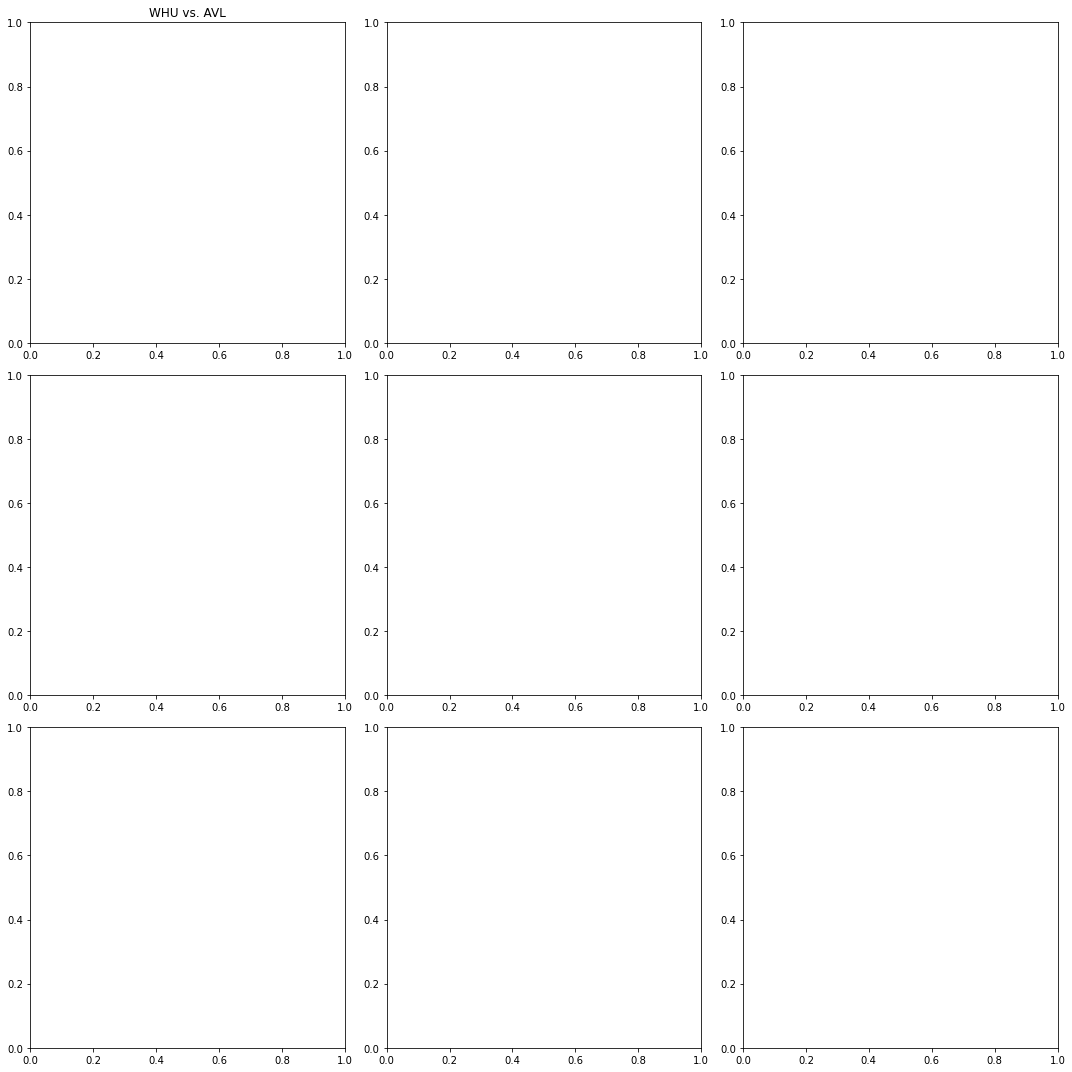

Home team cpfc, cc 0.8506493506493507, cfc 0.027494001032662464, hc 0.9402035623409665
Away team southamptonfc, cc 0.7705882352941177, cfc 0.027442691214416653, hc 0.899491094147582
Positive polarity
Home team cpfc, cc 0.717948717948718, cfc 0.12039141173926692, hc 0.8630952380952379
Away team southamptonfc, cc 0.8484848484848485, cfc 0.12238317303828349, hc 0.9345238095238094
Negative polarity
Home team cpfc, cc 0.8653846153846154, cfc 0.07757033478730935, hc 0.9444444444444446
Away team southamptonfc, cc 0.6818181818181818, cfc 0.0764302191184262, hc 0.8407407407407412
Neutral polarity
Home team cpfc, cc 0.8985507246376812, cfc 0.060495432229450634, hc 0.9596774193548389
Away team southamptonfc, cc 0.8051948051948052, cfc 0.06026028227973387, hc 0.916666666666667
Home team fulhamfc, cc 0.49159663865546216, cfc 0.02166881961172886, hc 0.6538461538461527
Away team arsenal, cc 0.740506329113924, cfc 0.02174758678630192, hc 0.881766381766381
Positive polarity
Home team fulhamfc, cc 0.508

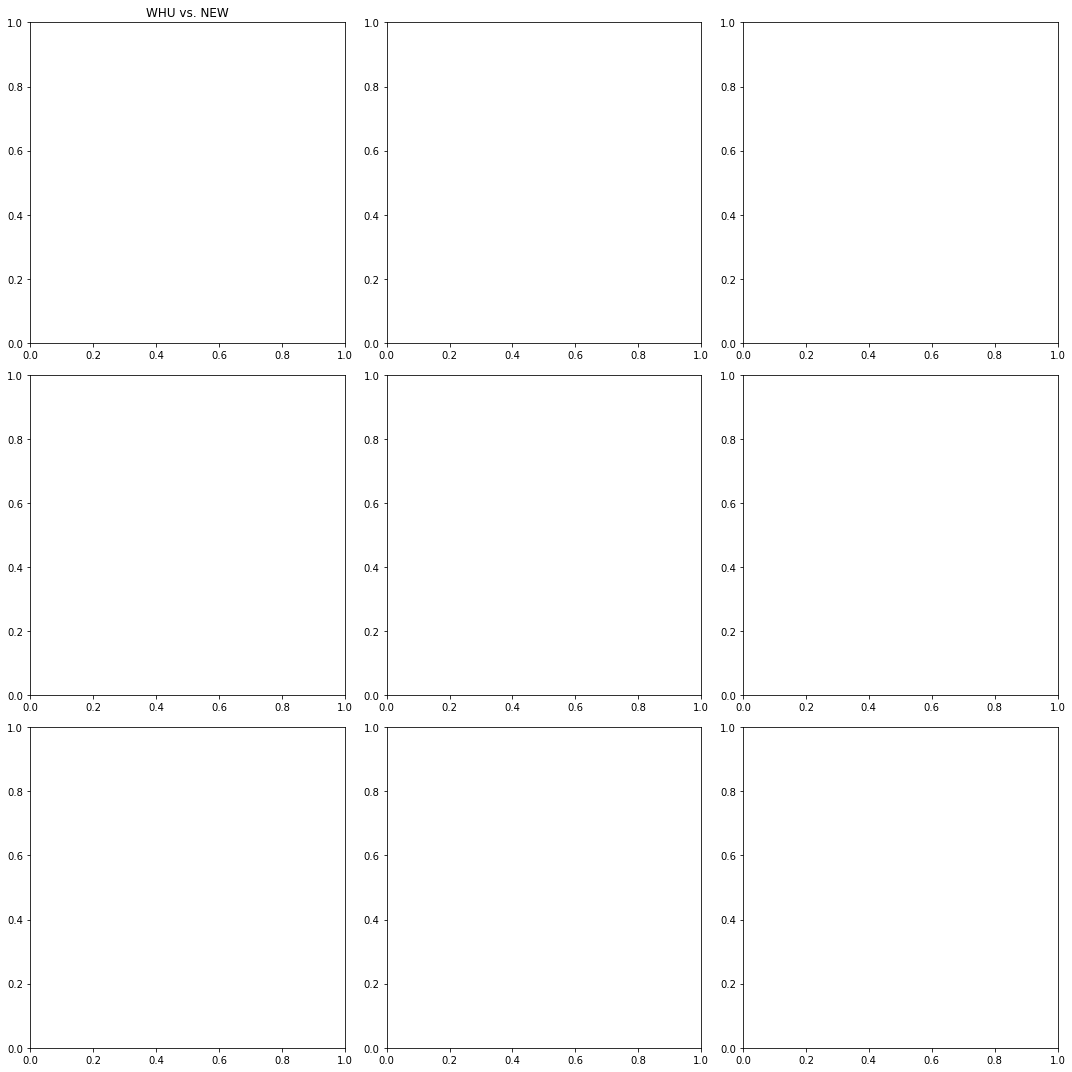

Home team arsenal, cc 0.937799043062201, cfc 0.014424669630690633, hc 0.977040816326531
Away team westham, cc 0.5490196078431373, cfc 0.014328040740608254, hc 0.7253401360544229
Positive polarity
Home team arsenal, cc 0.8985507246376812, cfc 0.04101490390302034, hc 0.9596774193548389
Away team westham, cc 0.4806201550387597, cfc 0.03917703664384426, hc 0.637096774193549
Negative polarity
Home team arsenal, cc 0.9367088607594937, cfc 0.041473164249107713, hc 0.9752252252252251
Away team westham, cc 0.6218487394957983, cfc 0.040825869829037915, hc 0.7950450450450457
Neutral polarity
Home team arsenal, cc 0.9545454545454546, cfc 0.04540857789199098, hc 0.9814814814814815
Away team westham, cc 0.5431034482758621, cfc 0.04477741712899481, hc 0.7169312169312179
Home team avfcofficial, cc 0.96045197740113, cfc 0.019529742023991707, hc 0.985294117647059
Away team sheffieldunited, cc 0.6367041198501873, cfc 0.0194086122061794, hc 0.8088235294117657
Positive polarity
Home team avfcofficial, cc 0

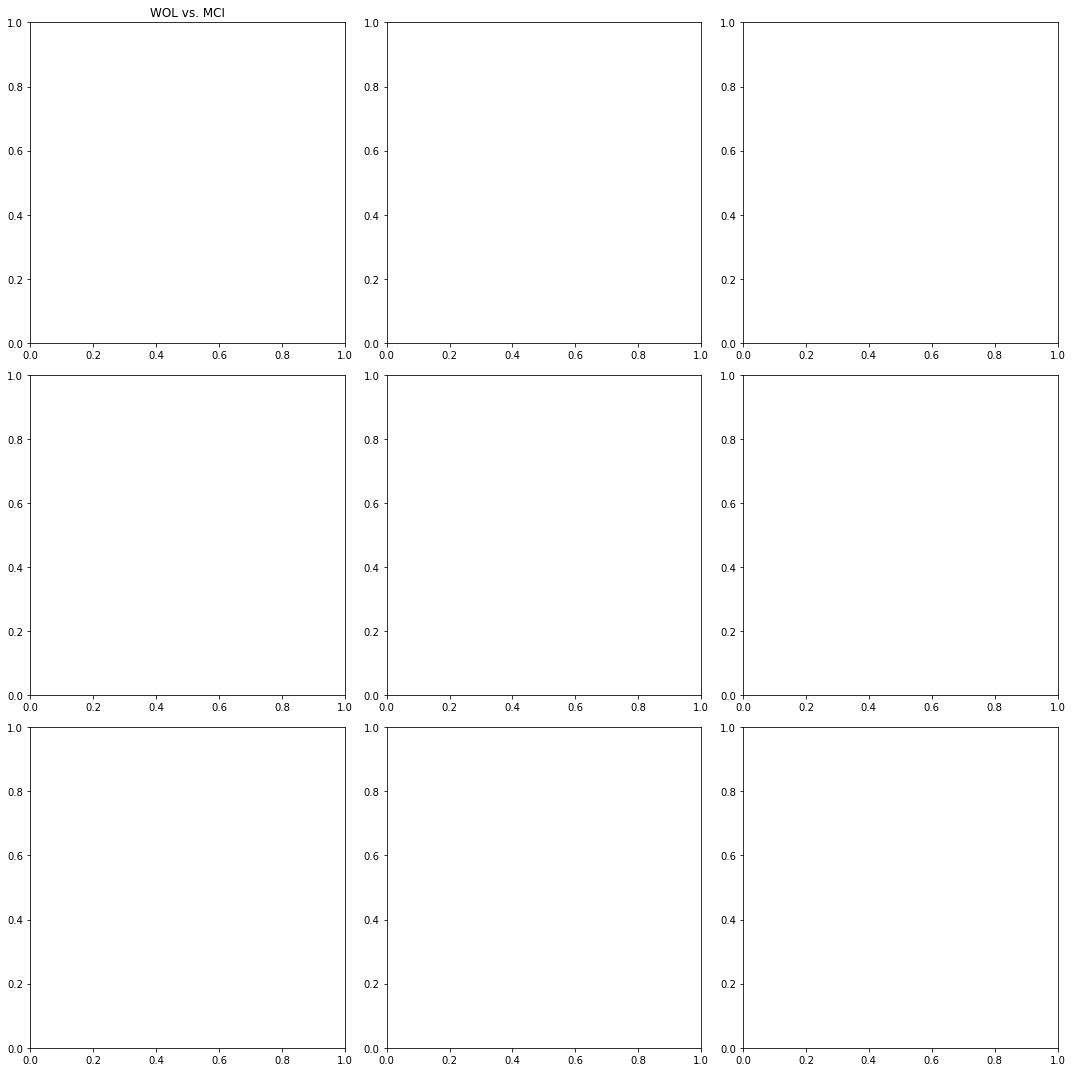

Home team burnleyofficial, cc 0.7195767195767195, cfc 0.024868526639006103, hc 0.868872549019607
Away team southamptonfc, cc 0.7953216374269005, cfc 0.024918675310886842, hc 0.9129901960784308
Positive polarity
Home team burnleyofficial, cc 0.5714285714285714, cfc 0.07412362718851949, hc 0.7453703703703699
Away team southamptonfc, cc 0.7659574468085106, cfc 0.0764656762639731, hc 0.8935185185185185
Negative polarity
Home team burnleyofficial, cc 0.7307692307692307, cfc 0.06162182508919501, hc 0.8742690058479536
Away team southamptonfc, cc 0.8636363636363636, cfc 0.06205363065487736, hc 0.9444444444444446
Neutral polarity
Home team burnleyofficial, cc 0.8, cfc 0.06958764921104608, hc 0.9134615384615388
Away team southamptonfc, cc 0.7536231884057971, cfc 0.06938626518032298, hc 0.8878205128205132
Home team cpfc, cc 0.6686746987951807, cfc 0.026280013612370687, hc 0.8333333333333321
Away team everton, cc 0.75, cfc 0.026371372946946824, hc 0.8873873873873867
Positive polarity
Home team cpf

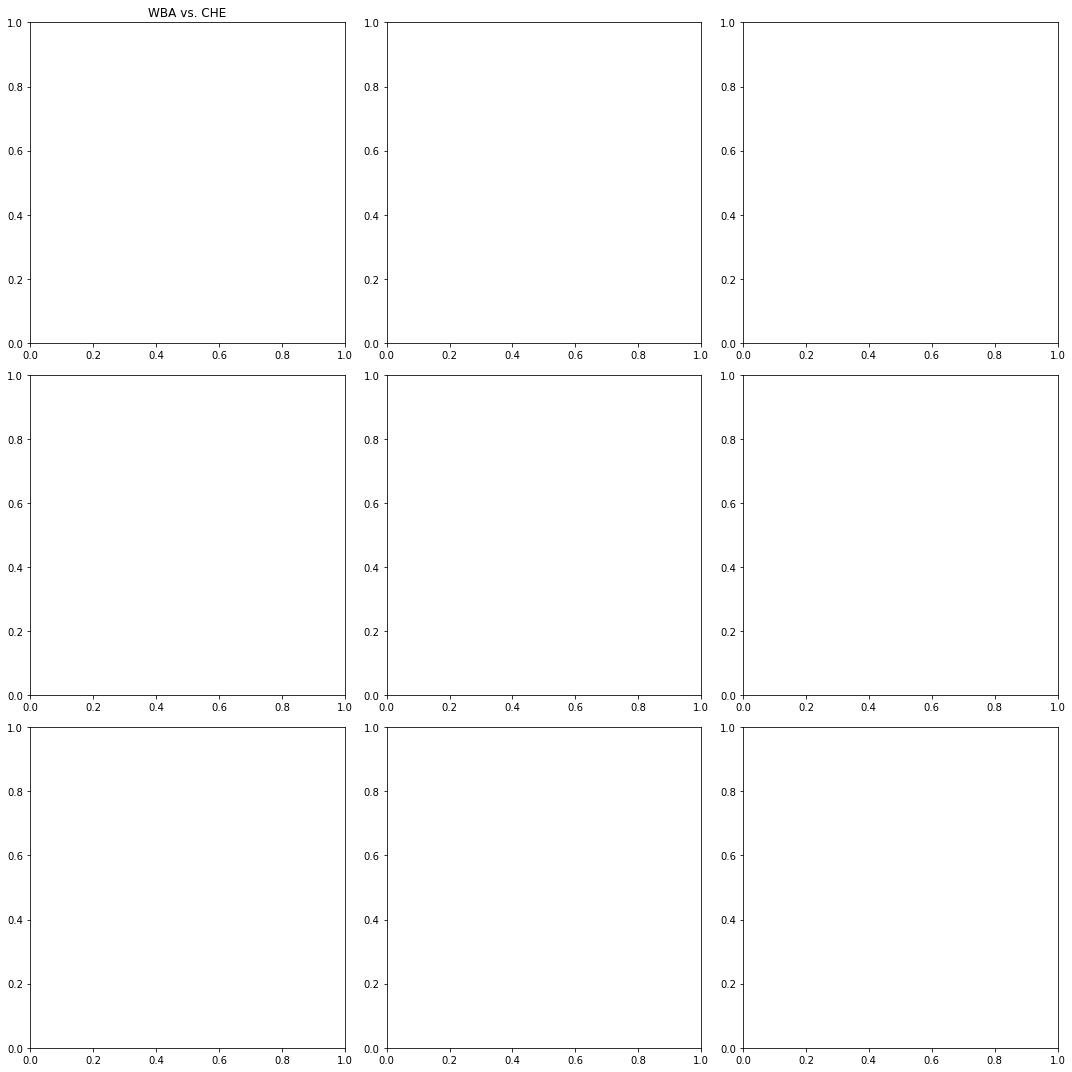

Home team arsenal, cc 0.9727272727272728, cfc 0.02386691588540986, hc 0.9890965732087227
Away team sheffieldunited, cc 0.421259842519685, cfc 0.022829279527924427, hc 0.5404984423676029
Positive polarity
Home team arsenal, cc 0.8333333333333334, cfc 0.16796929977765634, hc 0.9222222222222223
Away team sheffieldunited, cc 0.4411764705882353, cfc 0.1325993155597631, hc 0.5666666666666665
Negative polarity
Home team arsenal, cc 0.9846153846153847, cfc 0.039044892204746585, hc 0.9921875
Away team sheffieldunited, cc 0.41830065359477125, cfc 0.03597315047780604, hc 0.5338541666666662
Neutral polarity
Home team arsenal, cc 0.9696969696969697, cfc 0.07965981760130639, hc 0.984375
Away team sheffieldunited, cc 0.4155844155844156, cfc 0.06985569454137419, hc 0.526041666666667
Home team chelseafc, cc 0.9166666666666666, cfc 0.028392787087371394, hc 0.9680134680134678
Away team cpfc, cc 0.4583333333333333, cfc 0.028188822040046958, hc 0.6043771043771058
Positive polarity
Home team chelseafc, cc 0

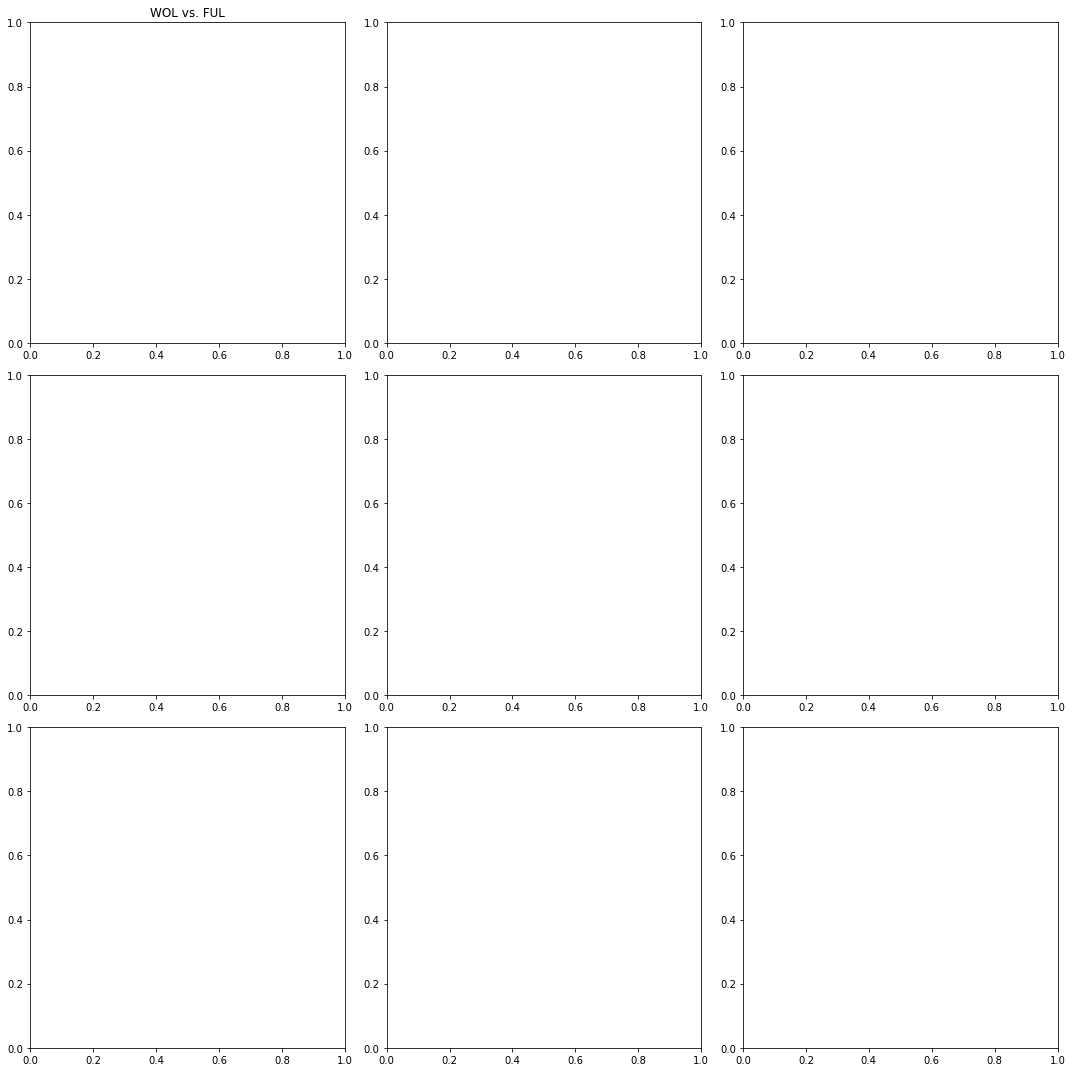

Home team arsenal, cc 0.897196261682243, cfc 0.03160308183705048, hc 0.9600694444444442
Away team lcfc, cc 0.6193548387096774, cfc 0.03125512253645293, hc 0.7934027777777763
Positive polarity
Home team arsenal, cc 0.782608695652174, cfc 0.15736779731331035, hc 0.8981481481481483
Away team lcfc, cc 0.6206896551724138, cfc 0.1509686670855476, hc 0.7870370370370372
Negative polarity
Home team arsenal, cc 0.9736842105263158, cfc 0.08236348939417974, hc 0.9864864864864865
Away team lcfc, cc 0.578125, cfc 0.0789901942773809, hc 0.7522522522522518
Neutral polarity
Home team arsenal, cc 0.8679245283018868, cfc 0.0671401268943421, hc 0.9456521739130437
Away team lcfc, cc 0.6666666666666666, cfc 0.06603065167021041, hc 0.8297101449275368
Home team officialbhafc, cc 0.75, cfc 0.035015858070296876, hc 0.8870967741935476
Away team wba, cc 0.75, cfc 0.035015858070297, hc 0.8870967741935476
Positive polarity
Home team officialbhafc, cc 0.75, cfc 0.13149601957490728, hc 0.8809523809523808
Away team wb

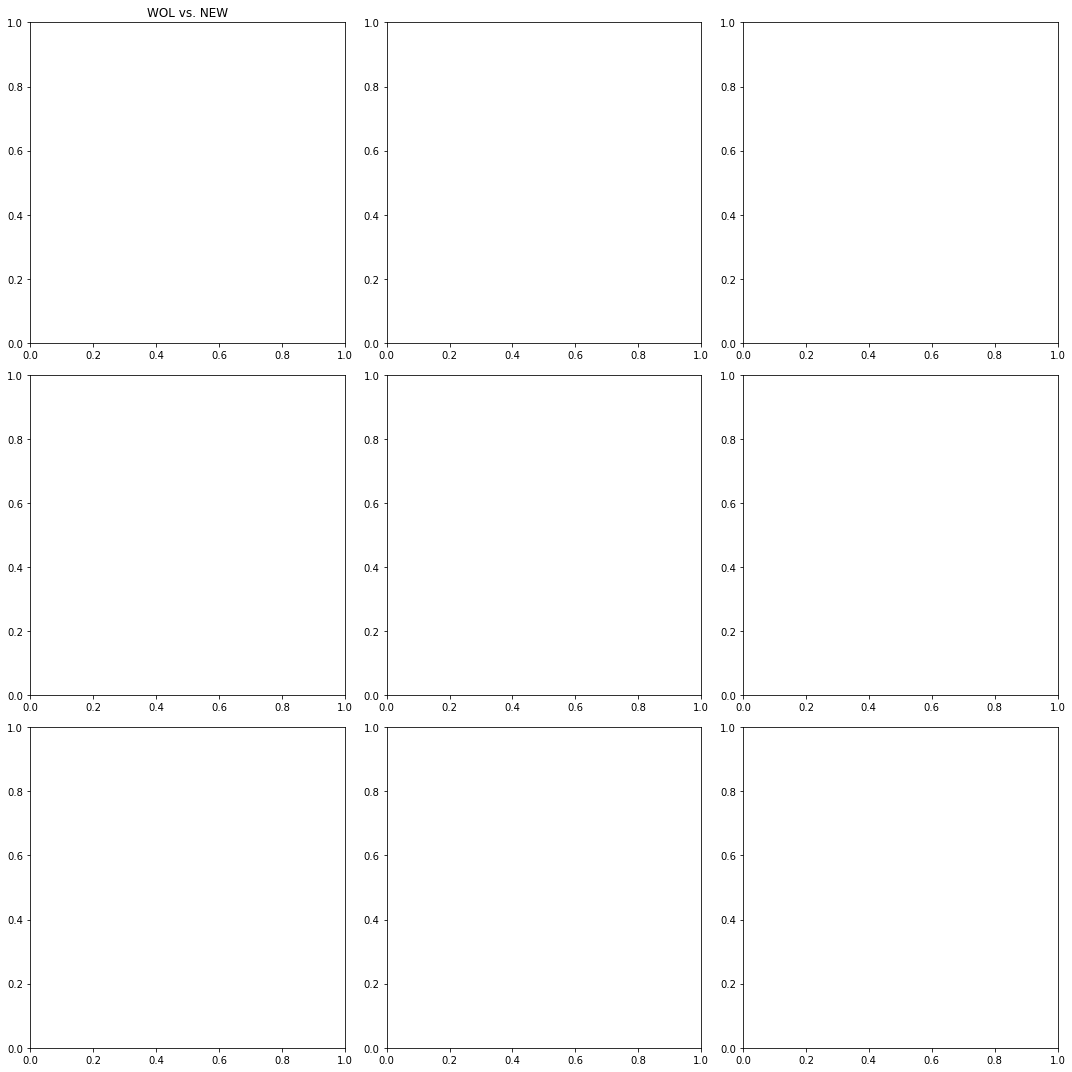

Home team avfcofficial, cc 0.726890756302521, cfc 0.018006860690524918, hc 0.8737957610789998
Away team southamptonfc, cc 0.7208333333333333, cfc 0.018005889859944044, hc 0.8699421965317937
Positive polarity
Home team avfcofficial, cc 0.6413043478260869, cfc 0.04614554443929436, hc 0.8107344632768368
Away team southamptonfc, cc 0.6704545454545454, cfc 0.046297597298385465, hc 0.8333333333333339
Negative polarity
Home team avfcofficial, cc 0.8089887640449438, cfc 0.04689552310826984, hc 0.9189814814814812
Away team southamptonfc, cc 0.7741935483870968, cfc 0.04681139593545118, hc 0.9004629629629631
Neutral polarity
Home team avfcofficial, cc 0.6746987951807228, cfc 0.05461937943047789, hc 0.8363095238095244
Away team southamptonfc, cc 0.7272727272727273, cfc 0.05488411982333203, hc 0.87202380952381
Home team burnleyofficial, cc 0.5991902834008097, cfc 0.02161457727771051, hc 0.7759009009008994
Away team chelseafc, cc 0.9673202614379085, cfc 0.02180347953958891, hc 0.9876126126126128
Pos

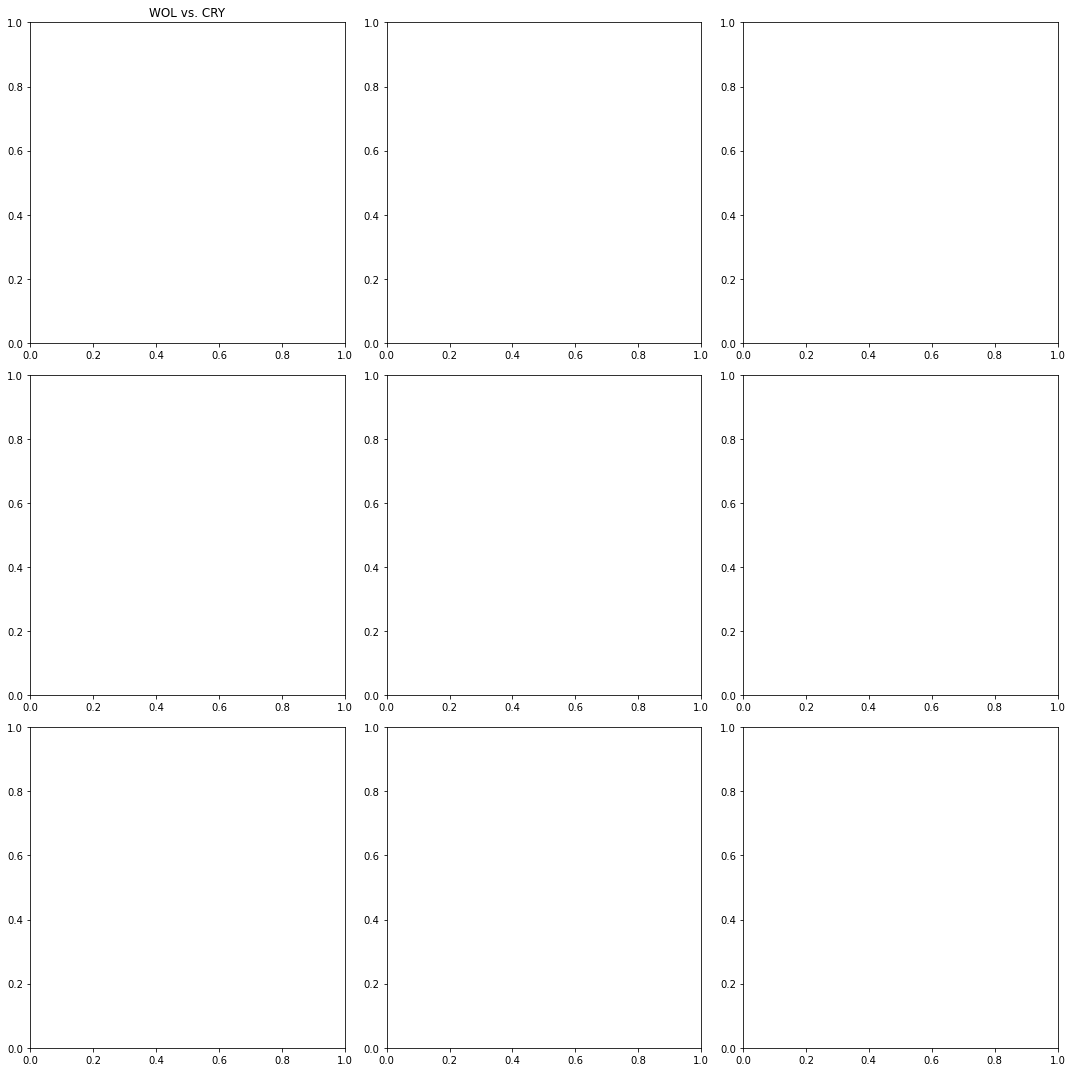

Home team officialbhafc, cc 0.8369565217391305, cfc 0.04339571864388673, hc 0.9329004329004325
Away team burnleyofficial, cc 0.6209677419354839, cfc 0.042953271226714954, hc 0.7943722943722951
Positive polarity
Home team officialbhafc, cc 0.6857142857142857, cfc 0.12295711276640002, hc 0.8402777777777776
Away team burnleyofficial, cc 0.5581395348837209, cfc 0.12028386705828203, hc 0.7291666666666665
Negative polarity
Home team officialbhafc, cc 0.9032258064516129, cfc 0.1155587213416486, hc 0.9583333333333333
Away team burnleyofficial, cc 0.6222222222222222, cfc 0.1111682810225289, hc 0.7916666666666663
Neutral polarity
Home team officialbhafc, cc 0.8809523809523809, cfc 0.08531832313318372, hc 0.9504504504504506
Away team burnleyofficial, cc 0.6166666666666667, cfc 0.0825969225169894, hc 0.7882882882882879


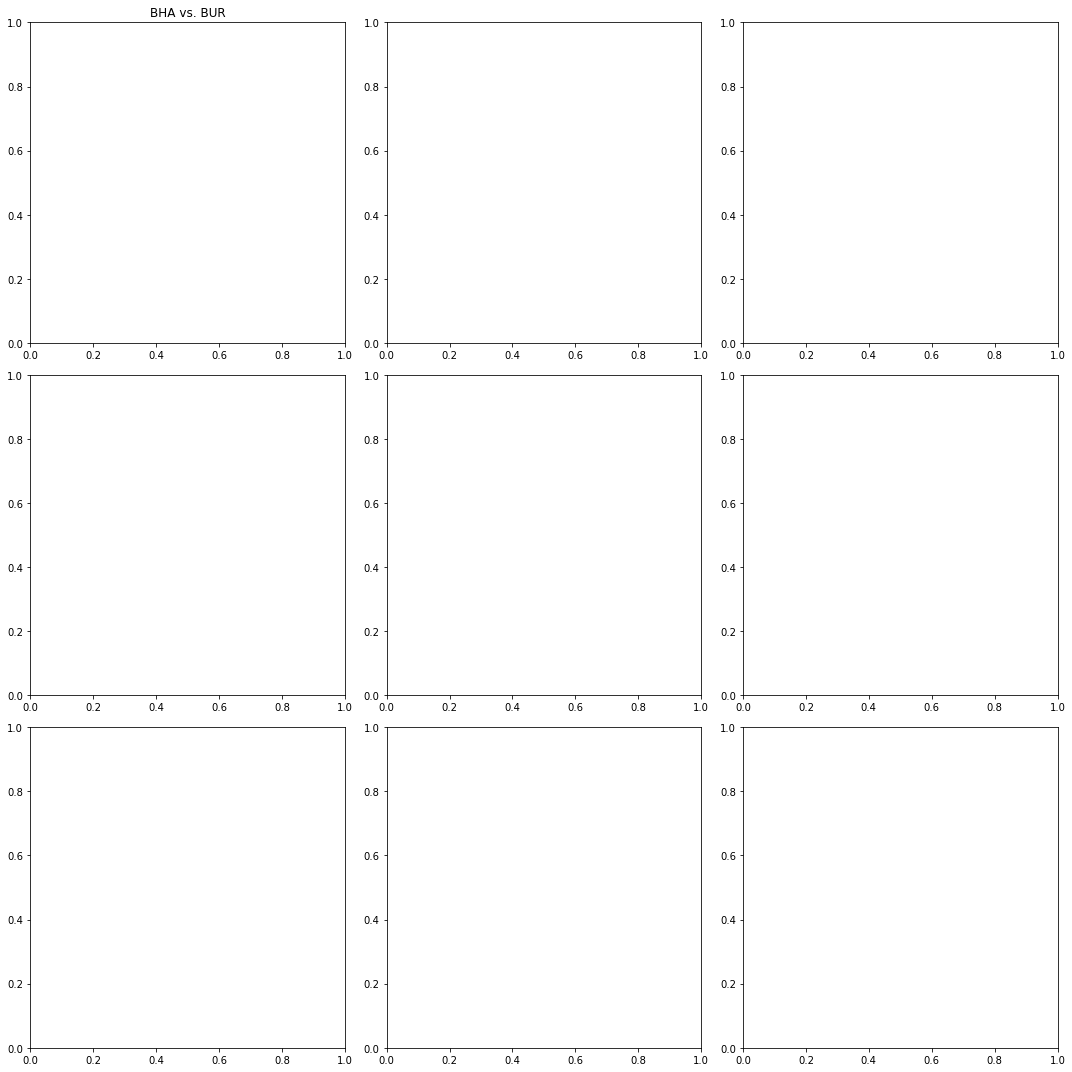

In [15]:
cc = pd.DataFrame()
for file_title in files:
    cc = per_week(file_title, cc)

In [19]:
target = [1, -1, 1, 0, -1, -1, 1, -1, 0, 0,
         -1, 1, 1, -1, -1, -1,
         1, 1, 1, -1, -1, -1, 1, 1, -1, -1,
         -1, -1, 0,
         -1, 0, 1, -1, 1, 1, 1, 1,
         -1, 1, 1, 0, 0, 0, -1, 0, -1,
         1, -1, -1, 1, -1, 1, 1,
         0]
cc["target"] = target

In [20]:
cc.head()

,n_cc_away,n_cc_home,n_cfc_away,n_cfc_home,n_hc_away,n_hc_home,neu_cc_away,neu_cc_home,neu_cfc_away,neu_cfc_home,...,o_cfc_home,o_hc_away,o_hc_home,p_cc_away,p_cc_home,p_cfc_away,p_cfc_home,p_hc_away,p_hc_home,target
0,0.391473,0.765152,0.017088,0.020163,0.480198,0.896040,0.452381,0.695122,0.038577,0.039414,...,0.009646,0.497807,0.901316,0.377880,0.828283,0.020296,0.025356,0.449187,0.928862,1
1,0.833333,0.760870,0.100996,0.100158,0.928571,0.890476,0.931818,0.759259,0.089196,0.088122,...,0.032966,0.933673,0.831633,0.731707,0.508475,0.088923,0.085510,0.872222,0.672222,-1
2,0.387097,0.884211,0.025267,0.026072,0.470238,0.954365,0.463636,0.822581,0.047450,0.049140,...,0.010322,0.533482,0.929315,0.419492,0.773438,0.020471,0.021986,0.537037,0.900673,1
3,0.661765,0.459184,0.048054,0.045473,0.825926,0.603704,0.634921,0.493827,0.057121,0.055718,...,0.014622,0.817673,0.607383,0.626087,0.452830,0.027301,0.025316,0.798611,0.594907,0
4,0.618421,0.602564,0.053026,0.052811,0.790780,0.776596,0.585714,0.683333,0.062003,0.062694,...,0.021554,0.789973,0.806233,0.623377,0.607595,0.052544,0.052473,0.795139,0.781250,-1


In [78]:
def study(data):
    df = pd.DataFrame()
    df["hc_p_home"] = data["o_hc_home"]-data["p_hc_home"]
    df["hc_n_home"] = data["o_hc_home"]-data["n_hc_home"]
    df["hc_neu_home"] = data["o_hc_home"]-data["neu_hc_home"]
    df["hc_p_away"] = data["o_hc_away"]-data["p_hc_away"]
    df["hc_n_away"] = data["o_hc_away"]-data["n_hc_away"]
    df["hc_neu_away"] = data["o_hc_away"]-data["neu_hc_away"]
    """
    df["diff_o_hc"] = abs(data["o_hc_home"]-data["o_hc_away"])
    df["diff_p_hc"] = abs(data["p_hc_home"]-data["p_hc_away"])
    df["diff_n_hc"] = abs(data["n_hc_home"]-data["n_hc_away"])
    df["diff_neu_hc"] = abs(data["neu_hc_home"]-data["neu_hc_away"])
    """
    df["diff_o_cc"] = abs(data["o_cc_home"]-data["o_cc_away"])
    df["diff_p_cc"] = abs(data["p_cc_home"]-data["p_cc_away"])
    df["diff_n_cc"] = abs(data["n_cc_home"]-data["n_cc_away"])
    df["diff_neu_cc"] = abs(data["neu_cc_home"]-data["neu_cc_away"])
    """
    df["diff_o_cfc"] = abs(data["o_cfc_home"]-data["o_cfc_away"])
    df["diff_p_cfc"] = abs(data["p_cfc_home"]-data["p_cfc_away"])
    df["diff_n_cfc"] = abs(data["n_cfc_home"]-data["n_cfc_away"])
    df["diff_neu_cfc"] = abs(data["neu_cfc_home"]-data["neu_cfc_away"])
    """
    df["o_hc_home"] = data["o_hc_home"]
    df["o_hc_away"] = data["o_hc_away"]
    df["p_hc_home"] = data["p_hc_home"]
    df["p_hc_away"] = data["p_hc_away"]
    df["n_hc_home"] = data["n_hc_home"]
    df["n_hc_away"] = data["n_hc_away"]
    df["neu_hc_home"] = data["neu_hc_home"]
    df["neu_hc_away"] = data["neu_hc_away"]
    df["target"] = data["target"]
    return df

In [79]:
# This returns the correlation matrix, as well the features correlated over a given trheshold
def get_correlation(data, target, column_names, corr_method, target_name, thresh=0.5):
    df = pd.DataFrame(data, columns=column_names)
    df[target_name] = target
    X = df.drop(target_name,1)   #Feature Matrix
    y = df[target_name] 
    
    #Using Spearman Correlation
    corr = df.corr(method=corr_method)
    
    #Correlation with output variable biggest magnitude
    cor_target = abs(corr[target_name])
    #Selecting highly correlated features
    relevant_features = cor_target[cor_target>thresh]
    relevant_features = relevant_features.sort_values(ascending=False)
    
    return corr, relevant_features

# Use in the future
def heatmap_data(data, target, column_names, corr_method, target_name):
    #Using Spearman Correlation
    corr, _ = get_correlation(data, target, column_names, corr_method, target_name)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap='mako', vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Features vs Target")
    plt.show()

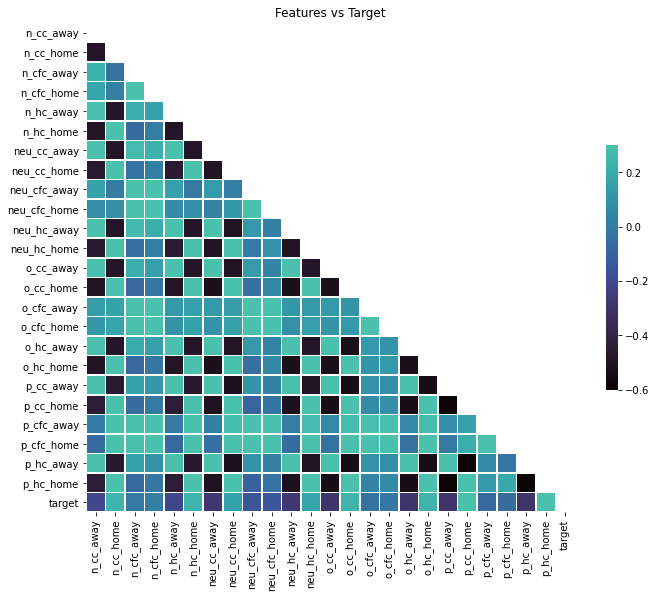

In [80]:
heatmap_data(cc, target, cc.columns, 'spearman', 'target')

In [81]:
_, relevant_features = get_correlation(cc, target, cc.columns, 'spearman', 'target', thresh=0.3)
print(relevant_features)

target       1.000000
p_hc_home    0.376819
p_cc_home    0.364932
p_hc_away    0.301740
p_cc_away    0.300546
Name: target, dtype: float64


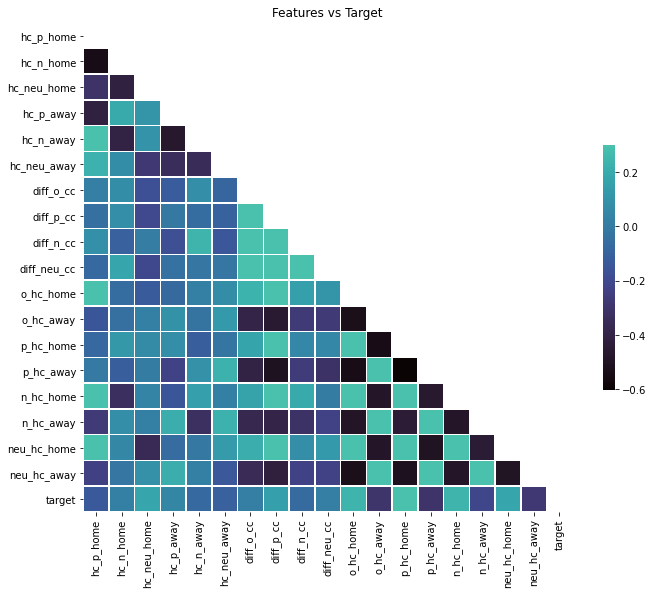

In [82]:
new_cc = study(cc)
heatmap_data(new_cc, target, new_cc.columns, 'spearman', 'target')

In [83]:
_, relevant_features = get_correlation(new_cc, target, new_cc.columns, 'spearman', 'target', thresh=0.1)
print(relevant_features)

target         1.000000
p_hc_home      0.376819
p_hc_away      0.301740
o_hc_away      0.296061
neu_hc_away    0.280258
n_hc_home      0.241665
o_hc_home      0.239886
n_hc_away      0.212008
hc_neu_home    0.179472
neu_hc_home    0.177949
diff_p_cc      0.158246
hc_p_home      0.133997
hc_neu_away    0.105560
Name: target, dtype: float64


In [84]:
from scipy.stats import f_oneway

def anova_test(data, target):
    cols = []
    for c in data.columns:
        F, p = f_oneway(data[c], target)
        if p <= 0.05:
            print("column = %s, p-val = %s" %(c, p))
            cols.append(c)
    return cols

In [85]:
cols = anova_test(cc, target)

column = n_cc_away, p-val = 6.423257610949385e-08
column = n_cc_home, p-val = 7.664609145700724e-09
column = n_hc_away, p-val = 5.145190236066417e-10
column = n_hc_home, p-val = 1.0765189238834429e-10
column = neu_cc_away, p-val = 7.685358320145479e-08
column = neu_cc_home, p-val = 1.4827988543019885e-08
column = neu_hc_away, p-val = 4.982490704465878e-10
column = neu_hc_home, p-val = 1.533845988098253e-10
column = o_cc_away, p-val = 1.5428053045141604e-07
column = o_cc_home, p-val = 1.2131459345801029e-08
column = o_hc_away, p-val = 7.975422788095661e-10
column = o_hc_home, p-val = 1.1350799414796069e-10
column = p_cc_away, p-val = 1.1473757349132636e-06
column = p_cc_home, p-val = 3.226442200284572e-08
column = p_hc_away, p-val = 5.760832679083103e-09
column = p_hc_home, p-val = 2.30484153727979e-10


In [86]:
new_cols = anova_test(new_cc, target)

column = diff_o_cc, p-val = 0.04015129459563734
column = diff_p_cc, p-val = 0.04840290465856531
column = diff_n_cc, p-val = 0.03199898578050547
column = diff_neu_cc, p-val = 0.03311176280722093
column = o_hc_home, p-val = 1.1350799414796069e-10
column = o_hc_away, p-val = 7.975422788095661e-10
column = p_hc_home, p-val = 2.30484153727979e-10
column = p_hc_away, p-val = 5.760832679083103e-09
column = n_hc_home, p-val = 1.0765189238834429e-10
column = n_hc_away, p-val = 5.145190236066417e-10
column = neu_hc_home, p-val = 1.533845988098253e-10
column = neu_hc_away, p-val = 4.982490704465878e-10


In [87]:
anova_df = cc[cols]

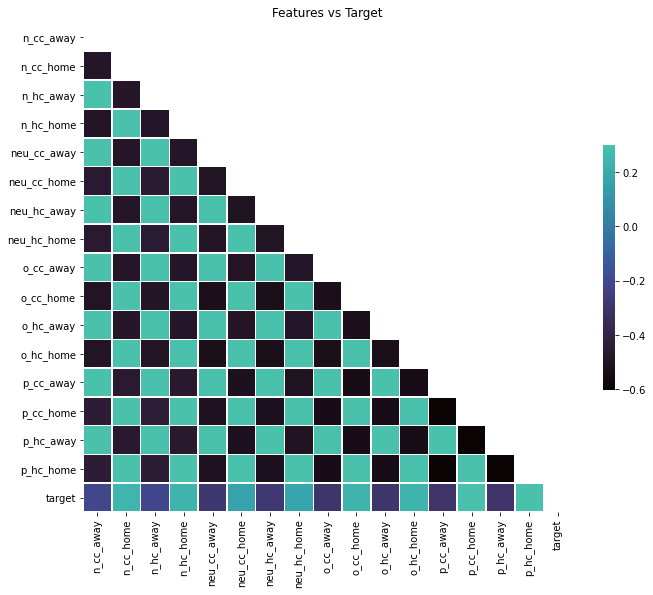

In [88]:
heatmap_data(anova_df, target, anova_df.columns, 'spearman', 'target')

In [89]:
_, relevant_features = get_correlation(anova_df, target, anova_df.columns, 'spearman', 'target', thresh=0.3)
print(relevant_features)

target       1.000000
p_hc_home    0.376819
p_cc_home    0.364932
p_hc_away    0.301740
p_cc_away    0.300546
Name: target, dtype: float64


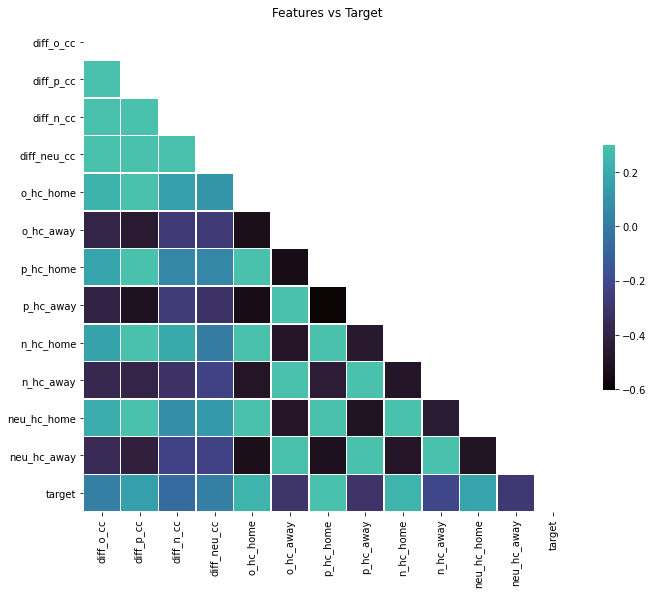

In [90]:
new_anova_df = new_cc[new_cols]
heatmap_data(new_anova_df, target, new_anova_df.columns, 'spearman', 'target')

In [91]:
_, relevant_features = get_correlation(new_anova_df, target, new_anova_df.columns, 'spearman', 'target', thresh=0.1)
print(relevant_features)

target         1.000000
p_hc_home      0.376819
p_hc_away      0.301740
o_hc_away      0.296061
neu_hc_away    0.280258
n_hc_home      0.241665
o_hc_home      0.239886
n_hc_away      0.212008
neu_hc_home    0.177949
diff_p_cc      0.158246
Name: target, dtype: float64


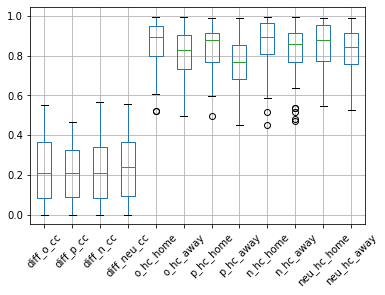

In [98]:
new_anova_df = new_anova_df.drop(columns=["target"])
new_anova_df.boxplot(rot=45)

In [97]:
new_anova_df.columns

Index(['diff_o_cc', 'diff_p_cc', 'diff_n_cc', 'diff_neu_cc', 'o_hc_home',
       'o_hc_away', 'p_hc_home', 'p_hc_away', 'n_hc_home', 'n_hc_away',
       'neu_hc_home', 'neu_hc_away', 'target'],
      dtype='object')

In [2]:
country = "GB"
season = "2019"
weekgame = "38"
file_title = country + '/' + season + '/' + weekgame + "_analysis.csv"
df = pd.read_csv(file_title)
print(df.shape)
df.head(5)

(1915, 21)


,Unnamed: 0,season,weekgame,home_team,away_team,favorite_count,lang,retweet_count,retweeted,text,...,verified,user,pre_label,no_mentions,support,with_emojis,sentiment,score,m_support,m_sentiment
0,0,2019,38,LEI,MUN,0,en,0,False,@DeporFinanzas @bardofstreets @LFC @FCBarcelon...,...,False,hassanthegr8,1,even an underperforming barca is at number 2,-1,@DeporFinanzas @bardofstreets @LFC @FCBarcelon...,-1,0,-1,-1
1,1,2019,38,LEI,MUN,0,en,0,False,@tpitch51 @premierleague @HolaItsAbdullah @LCF...,...,False,hassanthegr8,1,its all about today now,0,@tpitch51 @premierleague @HolaItsAbdullah @LCF...,1,0,0,1
2,2,2019,38,LEI,MUN,0,en,0,False,Excitement has now turned to nerves! Come on @...,...,False,DeanJohnsonMUFC,1,Excitement has now turned to nerves Come on on...,-1,Excitement has now turned to nerves! Come on @...,1,0,-1,1
3,3,2019,38,LEI,MUN,1,en,0,False,@ManUtd Don't be shit :-),...,False,SammonDStallion,1,Don t be shit,-1,@ManUtd Don't be shit good,-1,0,-1,-1
4,4,2019,38,LEI,MUN,1,en,0,False,Gonna watch the match between @ManUtd and @LC...,...,False,Riyel_19,1,Gonna watch the match between and Which team i...,0,Gonna watch the match between @ManUtd and @LCF...,0,0,0,0


0 0
Home team arsenal, cc 0.7728813559322034, cfc 0.009645733446247473, hc 0.9013157894736856
Away team watfordfc, cc 0.39929947460595444, cfc 0.009406666487967938, hc 0.49780701754385676
Positive polarity
Home team arsenal, cc 0.8282828282828283, cfc 0.025356488985296643, hc 0.9288617886178857
Away team watfordfc, cc 0.3778801843317972, cfc 0.020295926786005274, hc 0.44918699186991845
Negative polarity
Home team arsenal, cc 0.7651515151515151, cfc 0.020163486897200315, hc 0.8960396039603953
Away team watfordfc, cc 0.39147286821705424, cfc 0.01708755009424076, hc 0.48019801980198107
Neutral polarity
Home team arsenal, cc 0.6951219512195121, cfc 0.03941409315143121, hc 0.8508771929824567
Away team watfordfc, cc 0.4523809523809524, cfc 0.038577015321055994, hc 0.593567251461988
0 1
Home team burnleyofficial, cc 0.6666666666666666, cfc 0.03296633128011496, hc 0.8316326530612234
Away team officialbhafc, cc 0.8376068376068376, cfc 0.03315605452989309, hc 0.9336734693877546
Positive polarity

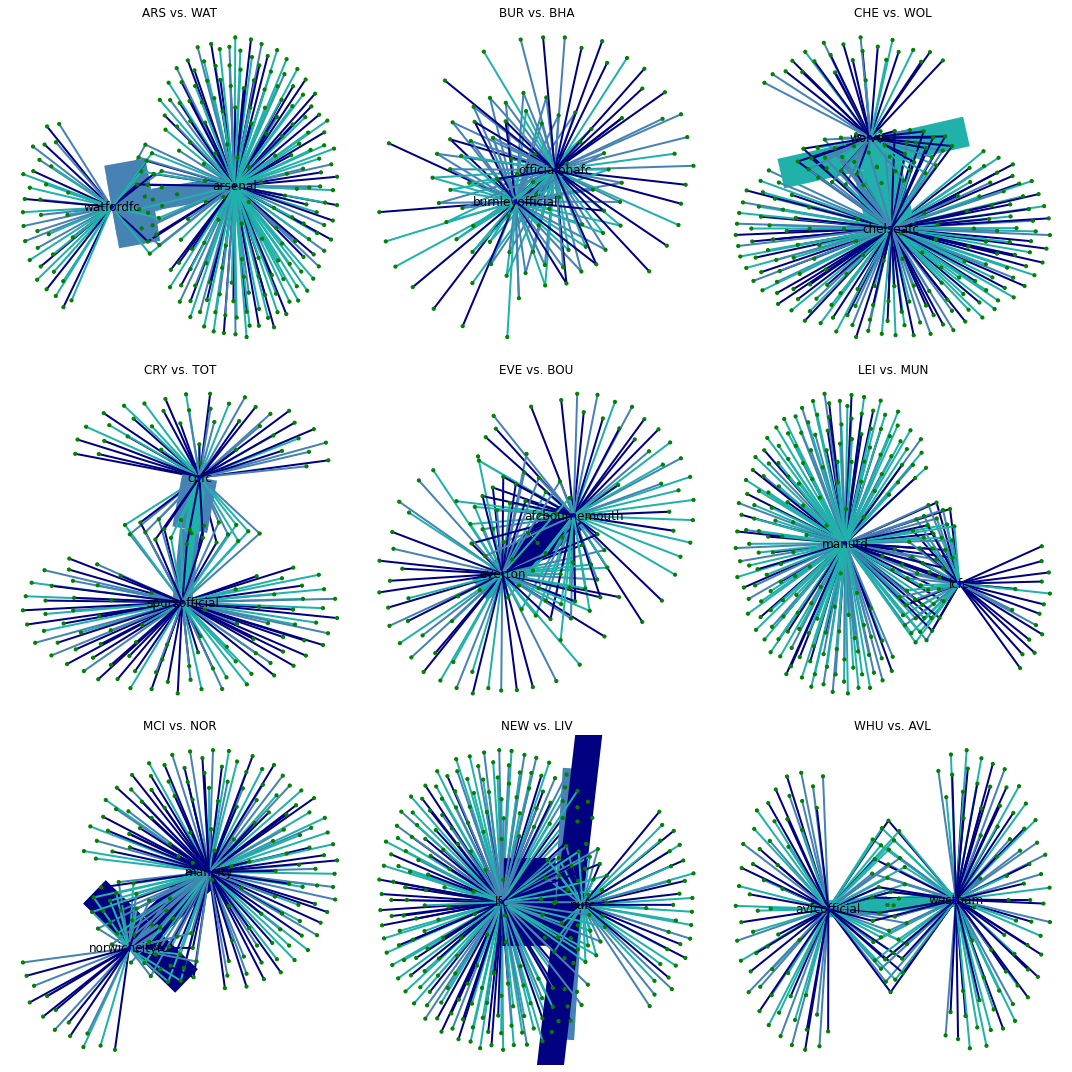

In [306]:
matches = df.groupby(['home_team','away_team'])
modified = df.groupby(['home_team','away_team','m_support']).count()
cc = pd.DataFrame()
# Labels balance
r = 3
c = 3
fig, axs = plt.subplots(r, c, figsize=(15,15))
# Create index mat
mat = [[i,j] for i in range(0, r) for j in range(0, c)]
i = 0
for key, val in matches:
    if key[0] != 'SU':
        print(mat[i][0], mat[i][1])
        dct_cc = create_graph(val.apply(lambda x: x), modified, dct, key, axs[mat[i][0], mat[i][1]])
        cc = cc.append(dct_cc, ignore_index=True)
        i = i + 1
fig.tight_layout()
plt.show()

In [309]:
target = [1, -1, 1, 0, -1, -1, 1, -1, 0]
cc["target"] = target